Install packages needed for colab \
**!pip install gym-anytrading gym stable-baselines3 sb3-contrib finta**

In [1]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from sb3_contrib import RecurrentPPO
# from stable_baselines3.common.evaluation import evaluate_policy

import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

from finta import TA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data

**To do:**
* Get the data from the API

In [2]:
def get_data(dates: list[str, str], ticker: str=None) -> pd.DataFrame:
    # read the data from yahoo finance API (yfinance)
    panel_data = data.DataReader(ticker, "yahoo", dates[0], dates[1]).reset_index()
    # df = pd.read_csv("gmedata.csv")

    # Define date as datetime
    panel_data["Date"] = pd.to_datetime(panel_data["Date"])

    # Sort the dates in ascending order 
    panel_data.sort_values('Date', ascending=True, inplace=True)

    return panel_data

In [3]:
ticker = "^GSPC"
df = get_data(ticker=ticker, dates=["2000-01-01", "2022-12-1"])

In [4]:
# df = pd.read_csv("gmedata.csv")
# df ["Date"] = pd.to_datetime(df["Date"])

In [5]:
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000,1455.219971
1,2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000,1399.420044
2,2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000,1402.109985
3,2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000,1403.449951
4,2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000,1441.469971
...,...,...,...,...,...,...,...
5762,2022-11-25,4034.020020,4020.760010,4023.340088,4026.120117,1706460000,4026.120117
5763,2022-11-28,4012.270020,3955.770020,4005.360107,3963.939941,3615430000,3963.939941
5764,2022-11-29,3976.770020,3937.649902,3964.189941,3957.629883,3546040000,3957.629883
5765,2022-11-30,4080.110107,3938.580078,3957.179932,4080.110107,6579360000,4080.110107


# Split Data
* Split into train, the first 80% of the data
* Split into test, between 80% and tha 100% of the data

In [6]:
def split_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    
    df_train = df[(df.index < sorted(df.index.values)[-int(0.2*len(sorted(df.index.values)))])]
    df_test = df[(df.index >= sorted(df.index.values)[-int(0.2*len(sorted(df.index.values)))])]
    
    return df_train, df_test


In [7]:
df_train, df_test = split_data(df)

In [8]:
def data_separated_plot(train_data: pd.DataFrame, test_data: pd.DataFrame):

    fig = plt.figure(figsize=(15, 10))
    st = fig.suptitle("Data Separation", fontsize=20)
    st.set_y(0.95)

    ax1 = fig.add_subplot(211)
    ax1.plot(train_data["Date"], train_data["Close"], label='Training data')
    ax1.plot(test_data["Date"], test_data["Close"], label='Test data')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Normalized Closing Returns')
    ax1.set_title("Close Price", fontsize=18)
    ax1.legend(loc="best", fontsize=12)
    ax1.grid(linestyle="--")

    # ax2 = fig.add_subplot(212)
    # ax2.plot(np.arange(train_data.shape[0]), train_data[:,4], label='Training data')
    # ax2.plot(np.arange(train_data.shape[0], train_data.shape[0]+val_data.shape[0]), val_data[:,4], label='Validation data')
    # ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), test_data[:,4], label='Test data')
    # ax2.set_xlabel('Date')
    # ax2.set_ylabel('Normalized Volume Changes')
    # ax2.set_title("Volume", fontsize=18)
    # ax2.legend(loc="best", fontsize=12)
    # ax2.grid()

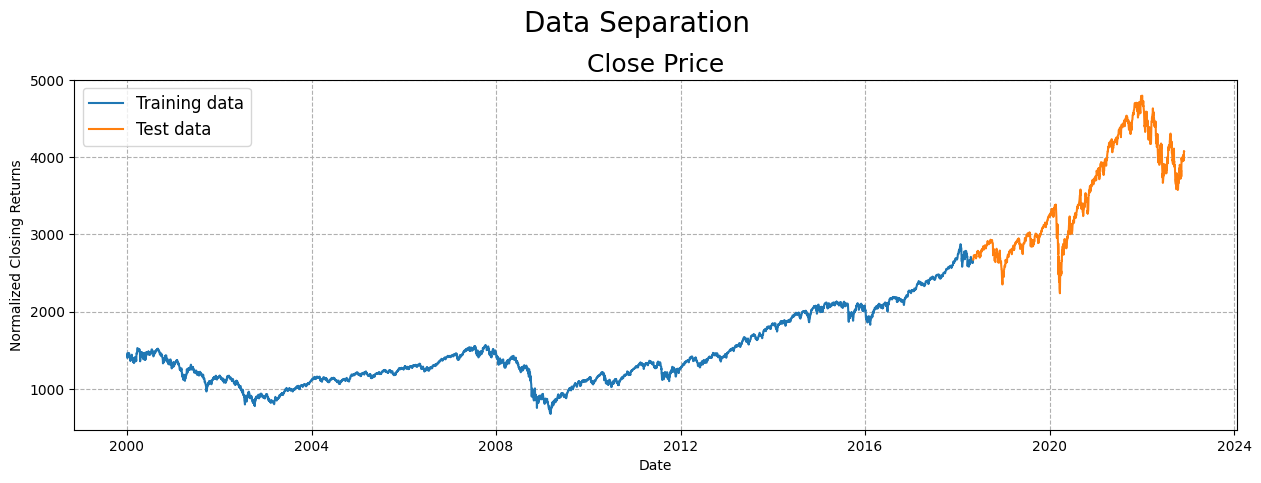

In [9]:
data_separated_plot(train_data=df_train, test_data=df_test)

In [10]:
df_train

,Date,High,Low,Open,Close,Volume,Adj Close
0,2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000,1455.219971
1,2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000,1399.420044
2,2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000,1402.109985
3,2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000,1403.449951
4,2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000,1441.469971
...,...,...,...,...,...,...,...
4609,2018-04-30,2682.870117,2648.040039,2682.510010,2648.050049,3749510000,2648.050049
4610,2018-05-01,2655.270020,2625.409912,2642.959961,2654.800049,3562820000,2654.800049
4611,2018-05-02,2660.870117,2631.699951,2654.239990,2635.669922,4047020000,2635.669922
4612,2018-05-03,2637.139893,2594.620117,2628.080078,2629.729980,3867530000,2629.729980


In [11]:
env = gym.make('stocks-v0', df=df_train, frame_bound=(5,len(df_train)), window_size=5)

In [12]:
env.action_space

Discrete(2)

info {'total_reward': 354.7286376953125, 'total_profit': 3.0961083393606217e-08, 'position': 1}


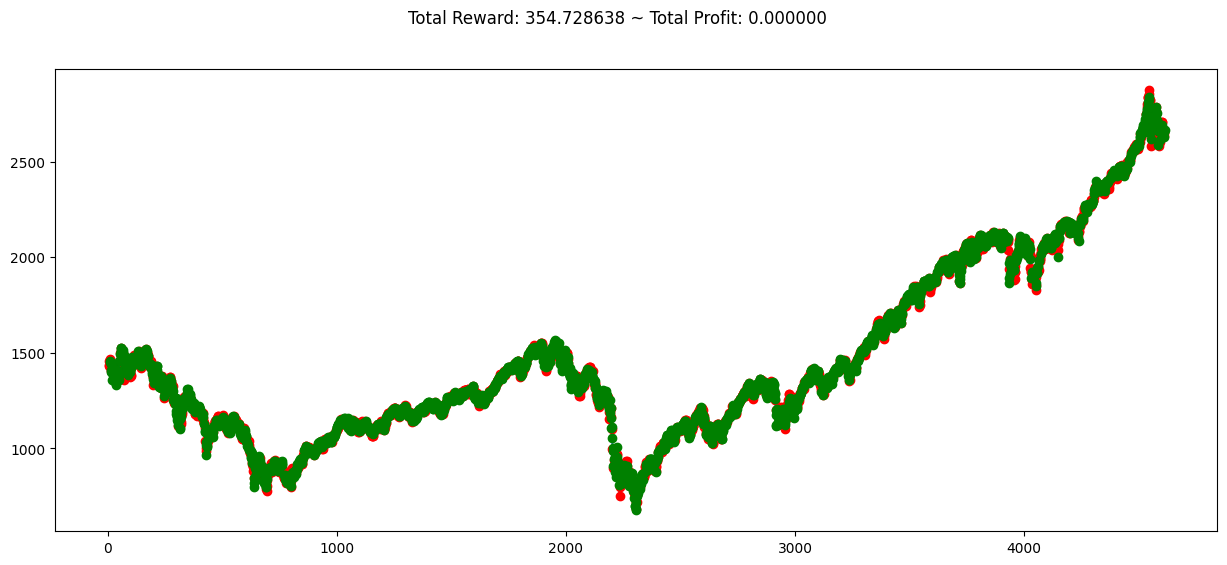

In [13]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [8]:
df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(",", "")))

In [9]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object

In [14]:
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

In [15]:
df.head(15)


,Date,High,Low,Open,Close,Volume,Adj Close,SMA,RSI,OBV
0,2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000,1455.219971,0.000000,0.000000,0.000000e+00
1,2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000,1399.420044,0.000000,0.000000,-1.009000e+09
2,2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000,1402.109985,0.000000,4.935296,7.650000e+07
3,2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000,1403.449951,0.000000,7.387289,1.168800e+09
4,2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000,1441.469971,0.000000,48.207236,2.394000e+09
5,2000-01-10,1464.359985,1441.469971,1441.469971,1457.599976,1064800000,1457.599976,0.000000,56.888814,3.458800e+09
6,2000-01-11,1458.660034,1434.420044,1457.599976,1438.560059,1014000000,1438.560059,0.000000,46.896137,2.444800e+09
7,2000-01-12,1442.599976,1427.079956,1438.560059,1432.250000,974600000,1432.250000,0.000000,44.129590,1.470200e+09
8,2000-01-13,1454.199951,1432.250000,1432.250000,1449.680054,1030400000,1449.680054,0.000000,52.470511,2.500600e+09
9,2000-01-14,1473.000000,1449.680054,1449.680054,1465.150024,1085900000,1465.150024,0.000000,58.405783,3.586500e+09


In [12]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [13]:
# class MyCustomEnv(StocksEnv):
#     _process_data = add_signals
    
# env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,50))

In [14]:
# env2.signal_features


NameError: name 'env2' is not defined

In [15]:
df.head()


,Date,Open,High,Low,Close,Volume,SMA,RSI,OBV
250,2020-03-16,3.93,4.57,3.90,4.37,4866696.0,0.0,0.000000,0.0
249,2020-03-17,4.40,4.65,4.11,4.23,3562210.0,0.0,0.000000,-3562210.0
248,2020-03-18,4.10,4.25,3.50,3.77,3651709.0,0.0,0.000000,-7213919.0
247,2020-03-19,3.71,4.20,3.55,4.19,5039539.0,0.0,43.394834,-2174380.0
246,2020-03-20,4.08,4.08,3.65,3.76,7722194.0,0.0,29.351457,-9896574.0


In [ ]:
# env_maker = lambda: env2
# env = DummyVecEnv([env_maker])

In [22]:
model = RecurrentPPO('MlpLstmPolicy', env, verbose=0)
model.learn(total_timesteps=500_000)

KeyboardInterrupt: 

In [ ]:
env = gym.make('stocks-v0', df=df_test, frame_bound=(5,len(df_train)), window_size=5)

In [21]:
# env = MyCustomEnv(df=df, window_size=12, frame_bound=(80,250))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 94.47, 'total_profit': 5.219187636885641, 'position': 0}


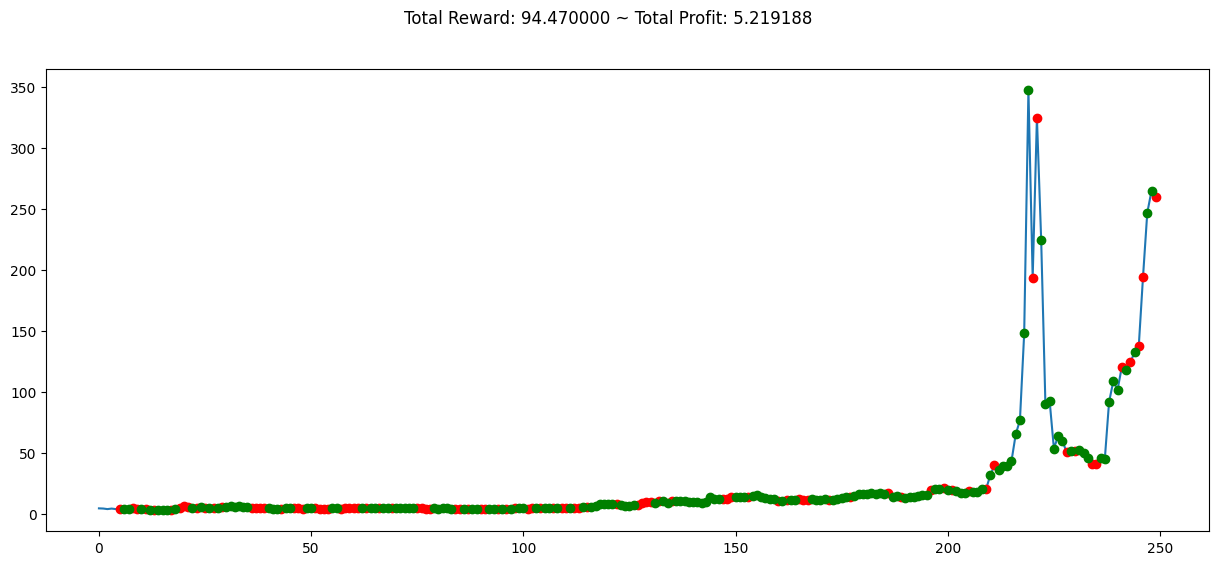

In [22]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [ ]:
# df.set_index("Date", inplace=True)
# df.head()

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2020-03-16,3.93,4.57,3.90,4.37,4866696.0,0.0,0.000000,0.0
2020-03-17,4.40,4.65,4.11,4.23,3562210.0,0.0,0.000000,-3562210.0
2020-03-18,4.10,4.25,3.50,3.77,3651709.0,0.0,0.000000,-7213919.0
2020-03-19,3.71,4.20,3.55,4.19,5039539.0,0.0,43.394834,-2174380.0
2020-03-20,4.08,4.08,3.65,3.76,7722194.0,0.0,29.351457,-9896574.0


In [ ]:
# env.prices

array([  4.72,   4.8 ,   4.38,   4.3 ,   4.27,   4.3 ,   4.2 ,   4.31,
         4.29,   4.19,   4.06,   4.03,   4.13,   4.18,   4.26,   4.07,
         4.13,   4.09,   3.94,   3.77,   3.88,   3.92,   4.06,   4.01,
         3.95,   3.92,   3.92,   3.97,   3.99,   4.  ,   4.13,   4.25,
         4.38,   4.06,   4.18,   4.34,   4.36,   4.5 ,   4.55,   4.56,
         4.44,   4.64,   4.51,   4.6 ,   4.56,   4.88,   4.92,   5.02,
         5.22,   5.69,   6.77,   7.11,   7.24,   7.17,   7.48,   7.31,
         6.19,   5.87,   6.43,   6.69,   7.03,   8.41,   8.91,   8.38,
         9.9 ,   9.92,   9.01,   9.1 ,   9.55,   9.93,  10.06,   9.69,
         9.3 ,   9.25,   9.1 ,   9.17,   9.19,  11.9 ,  11.4 ,  11.65,
        12.05,  11.99,  13.08,  13.38,  13.67,  13.8 ,  14.19,  14.55,
        13.26,  12.36,  11.78,  11.68,  10.36,  10.5 ,  10.63,  10.61,
        11.06,  11.32,  11.25,  10.83,  11.21,  10.97,  11.  ,  10.72,
        11.23,  11.56,  11.45,  12.54,  12.67,  13.3 ,  13.42,  14.88,
      

info {'total_reward': 378.6, 'total_profit': 24.553984257367254, 'position': 1}


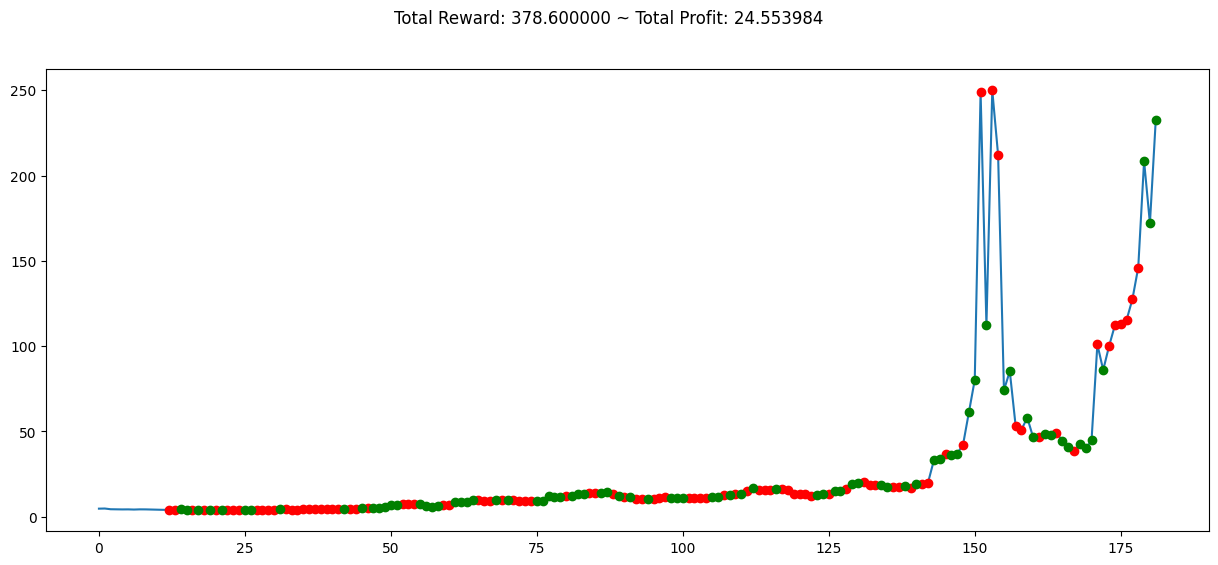

In [ ]:
# state = env.reset()
# while True:
#   action = env.action_space.sample()
#   n_state, reward, done, info = env.step(action)
#   if done:
#     print("info", info)
#     break

# plt.figure(figsize=(15,6))
# plt.cla()
# env.render_all()
# plt.show()

In [ ]:
# env.action_space

Discrete(2)

In [ ]:
# env_maker =  lambda: gym.make("stocks-v0", df=df, frame_bound=(5,100), window_size=5)
# env = DummyVecEnv([env_maker])